In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, RationalQuadratic
import itertools as it
from itertools import combinations

from sklearn.preprocessing import StandardScaler
import torch

## Load the Data

In [3]:
# File paths
input_file_path = "/Users/macponcho/a_IMPERIAL_COLLEGE/CAPSTONE Project - Black Box optimization/initial_data/function_2/initial_inputs.npy"
output_file_path = "/Users/macponcho/a_IMPERIAL_COLLEGE/CAPSTONE Project - Black Box optimization/initial_data/function_2/initial_outputs.npy"

# Load the data
inputs = np.load(input_file_path)
outputs = np.load(output_file_path)

# Convert to pandas DataFrame for easier manipulation and analysis
df = pd.DataFrame(inputs, columns=[f'Input_{i+1}' for i in range(inputs.shape[1])])
df['Output'] = outputs

df

,Input_1,Input_2,Output
0,0.665800,0.123969,0.538996
1,0.877791,0.778628,0.420586
2,0.142699,0.349005,-0.065624
3,0.845275,0.711120,0.293993
4,0.454647,0.290455,0.214965
5,0.577713,0.771973,0.023106
6,0.438166,0.685018,0.244619
7,0.341750,0.028698,0.038749
8,0.338648,0.213867,-0.013858
9,0.702637,0.926564,0.611205


### Function 2 is volatile, Outputs is then the Average of previous outputs. 
#### Running a parallel code with noise model that includes all historical data with all different outputs for same observations


In [5]:
#Adicion de datos conforme el concurso ha avanzado

#Datos pre-competencia que aparecieron
new_data_0=pd.DataFrame([{'Input_1':0.111111,'Input_2':0.111111,'Output':-0.044753}]) 
df=pd.concat([df,new_data_0],ignore_index=True)

# Data update - AVERAGE OUTPUTS
df.loc[len(df)]=[0.85,0.95,0.0847610337008687]
df.loc[len(df)]=[0.1,0.8,-0.0384556686425896]
df.loc[len(df)]=[9.99999e-01,1.00e-06,-0.00964427932199126]
df.loc[len(df)]=[0.444445,0.999999,0.0248007905464246]
df.loc[len(df)]=[0.7,0.5,0.583149483554304]
df.loc[len(df)]=[0.919191,0.323233,0.0366235330625148]
df.loc[len(df)]=[0.686868,0.313132,0.58617160051179]
df.loc[len(df)]=[0.747474,0.595959,0.359811413690163]
df.loc[len(df)]=[0.676767,0.444445,0.542174928459602]
df.loc[len(df)]=[0.689922,0.930232,0.605207486696438]
df.loc[len(df)]=[0.620155,0.224807,0.176381585977666]
df.loc[len(df)]=[0.728682,0.356589,0.527272285141736]
df.loc[len(df)]=[0.697674,0.333334,0.62670276954917]
df.loc[len(df)]=[0.759519,0.198397,0.305281602212308]
df.loc[len(df)]=[0.669339,0.362725,0.518067853435686]
df.loc[len(df)]=[0.723447,0.45491, 0.583412046554464]
df.loc[len(df)]=[0.693387,0.346693,0.610863338633929]
df.loc[len(df)]=[0.581162,0.462926,0.121033715048928]
df.loc[len(df)]=[0.675351,0.04008,0.507111728449984]
df.loc[len(df)]=[0.402201,0.514757,0.0267058455564719]
df.loc[len(df)]=[0.711423,0.450902,0.573760038269453]
df.loc[len(df)]=[0.513026,0.58517,0.714262071946754]
df.loc[len(df)]=[0.521042,0.58517,0.617527875760393]
df.loc[len(df)]=[0.496994,0.579158,0.799203501883715]

#Print
df

,Input_1,Input_2,Output
0,0.665800,0.123969,0.538996
1,0.877791,0.778628,0.420586
2,0.142699,0.349005,-0.065624
3,0.845275,0.711120,0.293993
4,0.454647,0.290455,0.214965
5,0.577713,0.771973,0.023106
6,0.438166,0.685018,0.244619
7,0.341750,0.028698,0.038749
8,0.338648,0.213867,-0.013858
9,0.702637,0.926564,0.611205


In [6]:
# Display basic statistics
print("Basic Statistical Summary:")
print(df.describe())

Basic Statistical Summary:
         Input_1    Input_2     Output
count  35.000000  35.000000  35.000000
mean    0.602980   0.466944   0.335548
std     0.216753   0.275960   0.270854
min     0.100000   0.000001  -0.065624
25%     0.475821   0.301794   0.037686
50%     0.675351   0.450902   0.359811
75%     0.717435   0.640489   0.583281
max     0.999999   0.999999   0.799204


In [7]:
# File paths SEGUNDO SET
input_file_path = "/Users/macponcho/a_IMPERIAL_COLLEGE/CAPSTONE Project - Black Box optimization/initial_data_secondSet/function_2/initial_inputs.npy"
output_file_path = "/Users/macponcho/a_IMPERIAL_COLLEGE/CAPSTONE Project - Black Box optimization/initial_data_secondSet/function_2/initial_outputs.npy"

# Load the data
inputs2 = np.load(input_file_path)
outputs2 = np.load(output_file_path)

# Convert to pandas DataFrame for easier manipulation and analysis
df2 = pd.DataFrame(inputs2, columns=[f'Input_{i+1}' for i in range(inputs.shape[1])])
df2['Output'] = outputs2

df2

,Input_1,Input_2,Output
0,0.331626,0.080499,-0.029954
1,0.100533,0.477595,0.083120
2,0.677932,0.873704,0.561143
3,0.134956,0.521158,0.013477
4,0.537156,0.244715,0.389944
5,0.659128,0.630642,0.422018
6,0.470452,0.533768,0.586957
7,0.721202,0.364506,0.569550
8,0.722734,0.438018,0.694832
9,0.240668,0.141229,0.033768


In [8]:
df = pd.concat([df, df2], ignore_index=True)
df


,Input_1,Input_2,Output
0,0.665800,0.123969,0.538996
1,0.877791,0.778628,0.420586
2,0.142699,0.349005,-0.065624
3,0.845275,0.711120,0.293993
4,0.454647,0.290455,0.214965
5,0.577713,0.771973,0.023106
6,0.438166,0.685018,0.244619
7,0.341750,0.028698,0.038749
8,0.338648,0.213867,-0.013858
9,0.702637,0.926564,0.611205


# Function 2: Optimising Noisy Models
### This corresponds to trying to optimise an unknown machine learning model. However, the initialization of the model is very important, meaning your observations will be very noisy, and the problem might have a lot of local optima! You are trying to make the model’s log-likelihood as large as possible.

After a few itertions, i realized that there was a lot of noise in the outputs for previous submissions, this help me start working different with this function. It was helpful that over the first weeks i did a lot of exploration as i started having mor robust information
After realizing the noise situation, i started using the average of historical outputs for each observation, it started heling to stabilized some information together with the overall improvements done to my model

Towards the last 4 weeks i started testing 2 new models where, instead of using the average i did 2 things:
1. Each historical observation was integrated to the data base, so, first submissions appear in the database more than 10 times with 10 different outputs. This creates a larger database and just ran my model with all this data.
2. Same as 1, but instead of having a large dataset with all submissions, grouped each input with mean and st deviation and then input that noise into the Gaussian process directly.

****

## Data exploration

In [12]:
# Display basic statistics
print("Basic Statistical Summary:")
print(df.describe())

# Check for any missing values
print("\nMissing values in the dataset:")
print(df.isnull().sum())

Basic Statistical Summary:
         Input_1    Input_2     Output
count  45.000000  45.000000  45.000000
mean    0.571126   0.458864   0.334867
std     0.227991   0.265528   0.269459
min     0.100000   0.000001  -0.065624
25%     0.444445   0.290455   0.036624
50%     0.665800   0.450902   0.389944
75%     0.711423   0.595959   0.583149
max     0.999999   0.999999   0.799204

Missing values in the dataset:
Input_1    0
Input_2    0
Output     0
dtype: int64


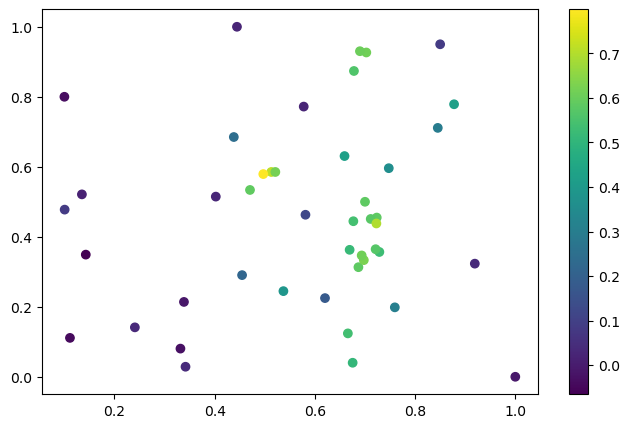

In [13]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(8)
plt.scatter(df['Input_1'], df['Input_2'], c = df['Output'])
plt.colorbar();

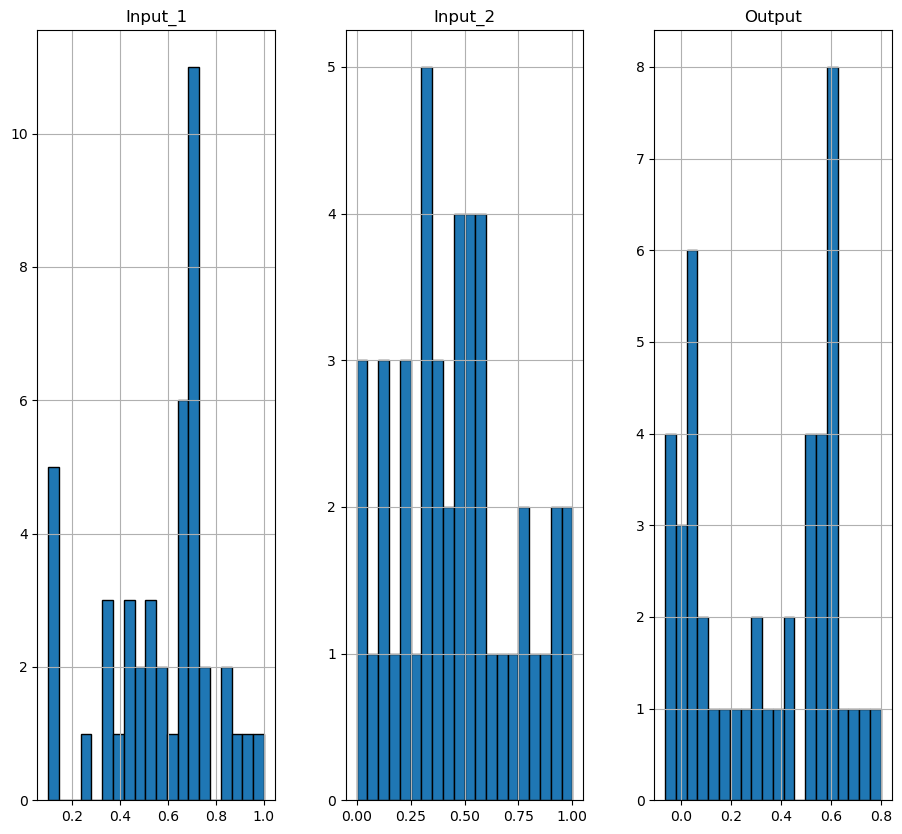

In [22]:
# Plot histograms for each column to understand distributions
df.hist(bins=20, figsize=(15, 10), layout=(-1, 4), edgecolor='black')
plt.subplots_adjust(hspace=0.5)
plt.show()

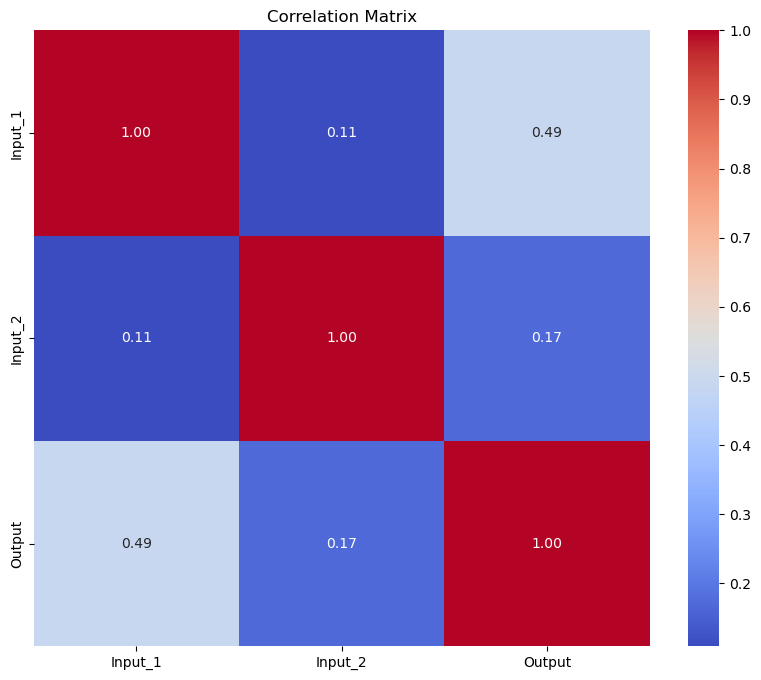

In [23]:
# Compute the correlation matrix
corr = df.corr()

# Generate a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix')
plt.show()

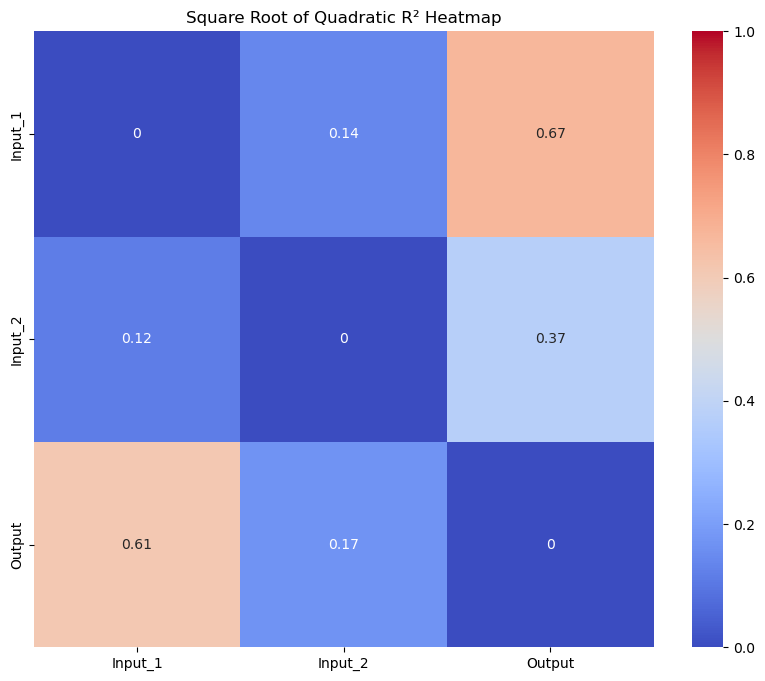

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def compute_quadratic_sqrt_r2(x, y):
    x = x[:, np.newaxis]
    polynomial_features = PolynomialFeatures(degree=2)
    x_poly = polynomial_features.fit_transform(x)
    
    model = LinearRegression()
    model.fit(x_poly, y)
    y_poly_pred = model.predict(x_poly)
    
    return np.sqrt(r2_score(y, y_poly_pred))

def quadratic_sqrt_r2_matrix(data):
    cols = data.columns
    sqrt_r2_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)
    
    for i in range(len(cols)):
        for j in range(len(cols)):
            if i != j:
                sqrt_r2_matrix.iloc[i, j] = compute_quadratic_sqrt_r2(data[cols[i]].values, data[cols[j]].values)
    
    return sqrt_r2_matrix

def plot_heatmap(sqrt_r2_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(sqrt_r2_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
    plt.title('Square Root of Quadratic R² Heatmap')
    plt.show()


# Compute square root of R² matrix
sqrt_r2_matrix = quadratic_sqrt_r2_matrix(df)

# Plot heatmap
plot_heatmap(sqrt_r2_matrix)

/opt/anaconda3/envs/sklearn_env/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


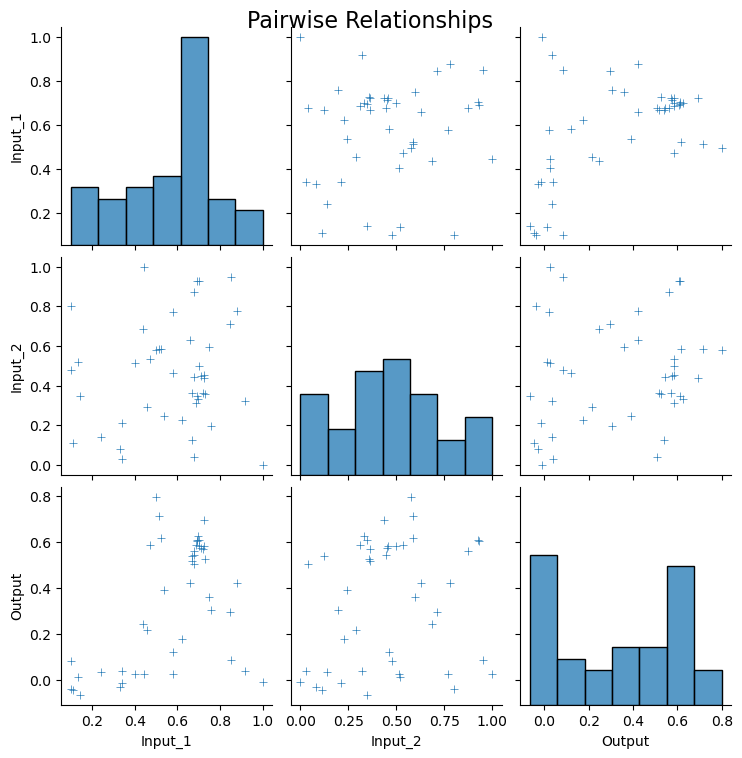

In [28]:
# Use pairplot to visualize the relationships between variables
sns.pairplot(df, kind='scatter', diag_kind='hist', markers='+')
plt.suptitle('Pairwise Relationships', verticalalignment='baseline', fontsize=16)
plt.show()

## Tracking of potential queries, submissions and historical notes

- Casi todo me da explorar un query=(0,1) porque es area inexplorada
- Voy a ir por el extremo again para armar los extremos
- tengo otras alternativas mas hacia 0.85,0.98 si uso lenghtscale mas pequeño, pèro empiezo por explorar el espacio

#### 4 May
Vamos a volver a submit el primero y voy a submit uno mas.
Pr si las dudas, voy a subir el original como segundo submit.
- [0.850000-0.950000]
- [0.100000-0.800000]

#### 10 may
Ç(0.444445,0.999999) y (1,0) cubren el 1.96 std y 2.6 std
Falta explorar mas en X2=0.5
- [0.999999-0.000001]
- [0.444445-0.999999]
- Si tuviera que hacer una tercera seria 
- [0.700000-0.500000]

#### 14 may
Encontramos otro CASI maximo en 0,7-0,5. 0.7 en X1 es una zona claramente importante
***
- Beta 1.96 [0.878787-0.313132]
- Beta casi CERO [0.696969-0.363637]
- Beta 2.6 [0.919191-0.323233]
- ONLY std [0.999999-0.353536]
- ******* Exploratiorio -- Vamos por [0.919191-0.323233] --- Muy negativo

#### 17 may
- *** len 0,3 noise 10-4
- Beta 1.96 [0.707070-0.313132], Beta casi CERO [0.696969-0.343435], ONLY std [0.000001-0.999999]
- *** len 0.2 noise 10-4
- Beta 1.96 [0.686868-0.313132], Beta casi CERO [0.646464-0.404041], Beta 2.6 [0.000001-0.999999]
- *** len 0.1
- Beta 2.6 [0.666666-0.323233], ONLY std [0.000001-0.565656], 
- ****** Con optimizador: 
- UCB [0.747474-0.595959], EI: [0.000001-0.767676]
- ******* VAMOS POR
- ******* [0.686868-0.313132], [0.747474-0.595959]

#### 1 jun
Vamos por el log likelihood
[0.676767-0.444445] * not bad pero no el maxio

#### 2 jun
Beta 1.96 [0.620155-0.224807] ++
Beta casi CERO [0.689922-0.930232] +
Beta 2.6 [0.604651-0.224807]
ONLY std [0.000001-0.558139]
Next query point EI: [0.155039-0.310078]
Next query point PI: [0.093024-0.790697]

- * VAMOS POR [0.689922-0.930232] y [0.620155-0.224807]

#### 12 jun
sin log like
Beta 1.96 [0.333334-0.488372]
Beta casi CERO [0.759689-0.248063]
Beta 2.6 [0.317830-0.503876]

con loglike
Beta 0.5 [0.697674-0.333334] ++
Beta 1.00 [0.713178-0.341086]
Beta 1.96 [0.728682-0.356589] +  **new max

con log like y cambiando rangos de length
Beta 0.5 [0.705426-0.333334]
Beta 1.00 [0.720930-0.341086]
Beta 1.96 [0.736434-0.356589]
Beta casi CERO [0.689922-0.325582]
Beta 2.6 [0.751937-0.356589]

** Vamos por
- [0.728682-0.356589] y [0.697674-0.333334]

#### 18 jun

Log like normal
Beta 0.5 [0.736434-0.302326]
Beta 1.00 [0.751937-0.279070]
Beta 1.96 [0.767441-0.201551]
Beta casi CERO [0.728682-0.317830]
Next query point EI: [0.155039-0.325582]
Next query point PI: [0.093024-0.790697]

Next query point UCB with Beta 1.96: [0.759519-0.198397]++
Next query point UCB with Beta 0.01: [0.727455-0.302605]
Next query point UCB with Beta 1: [0.743487-0.244489]
Next query point UCB with Beta 2.6: [0.769539-0.180361]
Next query point EI: [0.148297-0.308617]
Next query point PI: [0.088176-0.793587]


-*** Vamos por [0.759519-0.198397]

#### 22 jun
Next query point UCB with Beta 1.96: [0.669339-0.362725] ++
Next query point UCB with Beta 0.01: [0.693387-0.346693]
Next query point UCB with Beta 1: [0.683367-0.358717]
Next query point UCB with Beta 2.6: [0.729459-0.849699]
Next query point EI: [0.142285-0.348697]
Next query point PI: [0.142285-0.348697]

- ** Vamos por [0.669339-0.362725]

#### 24 jun **se añaden muchos datos
Next query point UCB with Beta 1.96: [0.767535-0.474950]
Next query point UCB with Beta 0.01: [0.723447-0.454910]++
Next query point UCB with Beta 1: [0.737475-0.464930]

- ** Vamos por[0.723447-0.454910] y [0.693387-0.346693] (del periodo anterior)

#### 28 jun
Best length scale: 0.029887332167158526
Best noise level: 0.030016140877250314
Next query point UCB with Beta 0.01: [0.723447-0.454910]
Next query point UCB with Beta 1: [0.671343-0.058116]
Next query point UCB with Beta 1.96: [0.673347-0.036072]
Next query point UCB with Beta 2.6: [0.673347-0.024048]

    Todos los datos pero sin modelo de ruido
    
    Next query point UCB with Beta 0.01: [0.717435-0.458918]
    Next query point UCB with Beta 1: [0.729459-0.462926]
    Next query point UCB with Beta 1.96: [0.675351-0.040080]++
    Next query point UCB with Beta 2.6: [0.677355-0.028056]

    Todo el modelo de ruido

    Next query point UCB with Beta 0.01: [0.693387-0.424850] tengo buena info aqui, no hace falta mas, 1.96
    Next query point UCB with Beta 1: [0.621242-0.452906]
    Next query point UCB with Beta 1.96: [0.581162-0.462926]**
    Next query point UCB with Beta 2.6: [0.571142-0.462926]
    
- Voy por [0.581162-0.462926]** y luego [0.675351-0.040080]

#### 1 jul

Con AVERAGE
Next query point UCB with Beta 0.01: [0.718359-0.447224]
Next query point UCB with Beta 1: [0.424712-0.524262]
Next query point UCB with Beta 1.96: [0.402201-0.514757] + Vamos a explorar aqui para tener datos o descartar
Next query point UCB with Beta 2.6: [0.391696-0.510755]

ALL data
Next query point UCB with Beta 0.01: [0.717435-0.452906]
Next query point UCB with Beta 1: [0.719439-0.452906]
Next query point UCB with Beta 1.96: [0.406814-0.513026] +
Next query point UCB with Beta 2.6: [0.394790-0.511022]

Noise model
Next query point UCB with Beta 0.01: [0.727455-0.406814]
Next query point UCB with Beta 1: [0.755511-0.424850]
Next query point UCB with Beta 1.96: [0.797595-0.456914]
Next query point UCB with Beta 2.6: [1.000000-0.605210]

- *** Vamos por [0.402201-0.514757]

#### 6 jul

Con average
Next query point UCB with Beta 0.01: [0.714715-0.439439]
Next query point UCB with Beta 1: [0.504505-0.564565]
Next query point UCB with Beta 1.96: [0.515516-0.578579]
Next query point UCB with Beta 2.6: [0.521522-0.584585]

ALL data
Next query point UCB with Beta 0.01: [0.711423-0.450902] ++
Next query point UCB with Beta 1: [0.503006-0.567134]
Next query point UCB with Beta 1.96: [0.515030-0.583166]

Noise model
Next query point UCB with Beta 0.01: [0.719439-0.406814]
Next query point UCB with Beta 1: [0.749499-0.422846]
Next query point UCB with Beta 1.96: [0.657315-1.000000]

- *** Vamos por algo cerca del maximo [0.711423-0.450902]

#### 9 jul

con average
Next query point UCB with Beta 0.01: [0.713714-0.439439]
Next query point UCB with Beta 1: [0.504505-0.568569]
Next query point UCB with Beta 1.96: [0.515516-0.581582]
Next query point UCB with Beta 2.6: [0.522523-0.587588]

ALL data
Next query point UCB with Beta 0.01: [0.709419-0.450902]
Next query point UCB with Beta 1: [0.501002-0.569138]
Next query point UCB with Beta 1.96: [0.513026-0.585170] ++ explorar **new max
Next query point UCB with Beta 2.6: [0.519038-0.591182]

Noise model
Next query point UCB with Beta 0.01: [0.723447-0.414830]
Next query point UCB with Beta 1: [0.753507-0.428858]
Next query point UCB with Beta 1.96: [0.797595-0.458918]
Next query point UCB with Beta 2.6: [1.000000-0.607214]

- ** Vamos por [0.513026-0.585170]

#### 13 jul

- con average
Next query point UCB with Beta 0.01: [0.508509-0.575576]
Next query point UCB with Beta 1: [0.515516-0.567568]
Next query point UCB with Beta 1.96: [0.529530-0.560561]
Next query point UCB with Beta 2.6: [0.569570-0.069069]

- ALL data
Next query point UCB with Beta 0.01: [0.509018-0.579158]
Next query point UCB with Beta 1: [0.511022-0.581162]
Next query point UCB with Beta 1.96: [0.521042-0.585170] ++ sigo explorando
Next query point UCB with Beta 2.6: [0.549098-0.601202]

- Noise model
Next query point UCB with Beta 0.01: [0.721443-0.412826]
Next query point UCB with Beta 1: [0.753507-0.424850]
Next query point UCB with Beta 1.96: [0.655311-1.000000]
Next query point UCB with Beta 2.6: [1.000000-0.607214]

- ** Vampos por [0.521042-0.585170]

#### 15 jul

- con average
- Next query point UCB with Beta 0.01: [0.498498-0.572573] 
Next query point UCB with Beta 1: [0.490490-0.579580]
Next query point UCB with Beta 1.96: [0.584585-0.067067]
Next query point UCB with Beta 2.6: [0.571572-0.065065]

- ALL data
Next query point UCB with Beta 0.01: [0.503006-0.577154]
Next query point UCB with Beta 0.5: [0.501002-0.577154]
Next query point UCB with Beta 1: [0.496994-0.579158] **
Next query point UCB with Beta 1.5: [0.492986-0.585170]
Next query point UCB with Beta 1.96: [0.741483-0.843687]

- Noise model
Next query point UCB with Beta 0.01: [0.721443-0.410822]
Next query point UCB with Beta 1: [0.755511-0.422846]
Next query point UCB with Beta 1.96: [0.655311-1.000000]
Next query point UCB with Beta 2.6: [1.000000-0.607214]

- ** Vamos por [0.496994-0.579158]

#### 20 jul

Average model
Next query point UCB with Beta 0.01: [0.487487-0.580581]
Next query point UCB with Beta 1: [0.480480-0.588589]
Next query point UCB with Beta 1.96: [0.474474-0.595596]
Next query point UCB with Beta 2.6: [0.577578-0.066066]

ALL data
Next query point UCB with Beta 0.01: [0.494990-0.579158]
Next query point UCB with Beta 0.5: [0.492986-0.581162]
Next query point UCB with Beta 1: [0.488978-0.587174] ++
Next query point UCB with Beta 1.5: [0.484970-0.593186]
Next query point UCB with Beta 1.96: [0.482966-0.597194]

Noise model

Next query point UCB with Beta 0.01: [0.721443-0.410822]
Next query point UCB with Beta 1: [0.755511-0.422846]
Next query point UCB with Beta 1.96: [0.655311-1.000000]
Next query point UCB with Beta 2.6: [1.000000-0.607214]

- VAmos por [0.488978-0.587174]


# New model

In [30]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.acquisition import gaussian_lcb, gaussian_ei, gaussian_pi
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import itertools as it
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress specific warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Assuming df is already loaded with data

X = df[['Input_1', 'Input_2']].values
y = df[['Output']].values

# Standardize inputs and outputs
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Define the search space for Bayesian Optimization
space = [
    Real(1e-3, 0.5, name='length_scale'),
    Real(1e-4, 1e-1, name='noise_level')
]

# Evaluation function (Log-Likelihood)
def evaluate_model(length_scale, noise_level):
    kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=length_scale) + WhiteKernel(noise_level=noise_level)
    GPR_model = GaussianProcessRegressor(kernel=kernel, alpha=noise_level)
    GPR_model.fit(X_scaled, y_scaled)
    log_likelihood = GPR_model.log_marginal_likelihood()
    return -log_likelihood

# Use the search space in the objective function
@use_named_args(space)
def objective(**params):
    return evaluate_model(**params)

# Perform Bayesian Optimization
res = gp_minimize(objective, space, n_calls=50, n_initial_points=10, random_state=32)

# Get the best parameters
best_length_scale = res.x[0]
best_noise_level = res.x[1]

print(f"Best length scale: {best_length_scale}")
print(f"Best noise level: {best_noise_level}")

# Define the best kernel
best_kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=best_length_scale) + WhiteKernel(noise_level=best_noise_level)

# Fit the Gaussian Process with the best parameters
GPR_model_best = GaussianProcessRegressor(kernel=best_kernel, alpha=best_noise_level)
GPR_model_best.fit(X_scaled, y_scaled)

# Flexible grid setup for predictions
def generate_grid(ranges, num_points):
    grid_axes = [np.linspace(start, end, num_points) for start, end in ranges]
    grid = np.array(list(it.product(*grid_axes)))
    return grid

# Define ranges for each input
input_ranges = [(0.0, 1.0), (0.00, 1.0)]  # Example ranges for two inputs

GG = 1000  # Number of data points for each variable in the grid
X_grid = generate_grid(input_ranges, GG)
X_grid_scaled = scaler_X.transform(X_grid)  # Scale the grid points

# Predictions using the surrogate model
mean_scaled, std_scaled = GPR_model_best.predict(X_grid_scaled, return_std=True)
mean_scaled = mean_scaled.reshape(-1, 1)  # Reshape to 2D array
mean = scaler_y.inverse_transform(mean_scaled).flatten()  # Inverse transform to original scale and flatten to 1D array
std = std_scaled * scaler_y.scale_[0]  # Scale standard deviation appropriately

# Acquisition function: UCB
beta = 0.01
acquisition_function_ucb = mean + beta * std

# Find the next query point (UCB)
idx_max_ucb = np.argmax(acquisition_function_ucb)
next_query_ucb = X_grid[idx_max_ucb]
formatted_row_ucb = '-'.join(format(x, ".6f") for x in next_query_ucb)
print(f"Next query point UCB with Beta {beta}: [{formatted_row_ucb}]")


# Test different beta values for UCB and other acquisition functions
for beta in [1, 1.96, 2.6]:
    acquisition_function = mean + beta * std
    idx_max = np.argmax(acquisition_function)
    next_query = X_grid[idx_max]
    formatted_row = '-'.join(format(x, ".6f") for x in next_query)
    print(f"Next query point UCB with Beta {beta}: [{formatted_row}]")



Best length scale: 0.21268472753517378
Best noise level: 0.011186372504940683
Next query point UCB with Beta 0.01: [0.487487-0.580581]
Next query point UCB with Beta 1: [0.480480-0.588589]
Next query point UCB with Beta 1.96: [0.474474-0.595596]
Next query point UCB with Beta 2.6: [0.577578-0.066066]


/opt/anaconda3/envs/sklearn_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


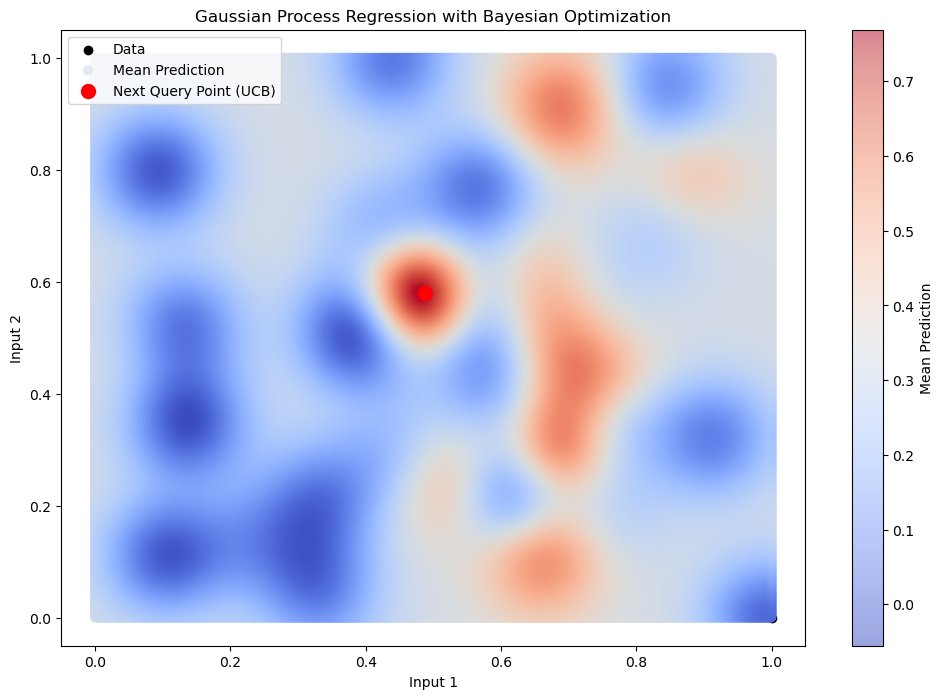

In [31]:
# Visualization
plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1], c='black', label='Data')
plt.scatter(X_grid[:, 0], X_grid[:, 1], c=mean, cmap='coolwarm', label='Mean Prediction', alpha=0.5)
plt.colorbar(label='Mean Prediction')
plt.scatter(next_query_ucb[0], next_query_ucb[1], color='red', s=100, label='Next Query Point (UCB)')
plt.title('Gaussian Process Regression with Bayesian Optimization')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.legend()
plt.show()
